## Analyze domain surface chemistry
This notebook analyzes the chemical properties on the surface of domains across the yeast proteome. This reflects figures 4D/E/F.

In [1]:
import numpy as np
import matplotlib
import os
import sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from shephard.apis.fasta import fasta_to_proteome
from shephard import interfaces
from shephard.tools import attribute_tools

from sparrow import Protein

from shephard import Proteome


from sparrow.data.amino_acids import VALID_AMINO_ACIDS

# lets you import from the code directory here
local_code_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'code'))

if local_code_path not in sys.path:
    sys.path.append(local_code_path)

from common_functions import annotate_with_quantiles

def normalize_array(arr):
    """
    Local function that takes in a list of array and normalizes
    it so it's rescaled to run between 0 and 1 regardless of what
    the actual values .

    Parameters
    
    """
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr
    

# Defining settings
The cell below defines the setting this notebook will be using. In principle you should not need to change any other settings...

In [2]:

# defines how we're defining our folded domains. option
domain_def = 'dodo'

# mode must either use 
# - "_count" (number of residues), or 
# - '' (which is the raw SASA in A^2) 
mode = '_count'


# smallest domain we'll consider
min_size_threshold = 90

# largest domain we'll consider
max_size_threshold = 1000

# threshold for SASA - domains where fraction of residues on surface ABOVE this threshold 
# are discarded
max_sasa_threshold = 1.0

# SASA mode (can only be v1)
sasa_mode = 'v1'

# SASA sensitivity factor (10 or 40 - this is precomputed, but 10 is more permisive than 40)
sasa_sensitivity_factor = 40

## Sanity check your settings, yo!
if domain_def not in ['chainsaw', 'dodo']:
    raise Exception('Invalid mode: must be "chainsaw" or "dodo"')

if mode not in ['_count', '']:
    raise Exception('Invalid mode: must be "_count" or ""')
    
if mode == '_count':
    mode_name = 'rescount'    
else:
    mode_name = 'sasa_area'



## Load proteome, annotate, and cast attributes
The code below does all the attribute casting to prepare the annotated proteomes

In [17]:
# load in the proteome object
yp = Proteome()
interfaces.si_proteins.add_proteins_from_file(yp,'../data/experimental_data/shprd_proteome_soluble_only_v2.tsv')

# define the string identty of the SASA attribute annotation
data_string = f'shprd_{domain_def}_domain_sasa_{sasa_mode}_{sasa_sensitivity_factor}.tsv'
print(f"Using {data_string}")

# annotate the proteome with those SASA attributes
interfaces.si_domains.add_domains_from_file(yp,f'../data/shprd_files/{data_string}')

# cast all values to float 
for d in yp.domains:
    attribute_tools.cast_attributes(d)

# cast protein numerical values; note we don't actually use most
# of these in this notebook, but we do this anyway for completeness
# NOTE this requires the most modern version of SHEPHARD on GitHub...
for p in yp:
    attribute_tools.cast_attributes(p,exclude=['lip_color', 'non_ref_score', 'refoldable', 'nonrefoldable', 'membrane_protein','non_ref','subcellular_localization'])

# precompute some sanity stuff
total_dodo_domains_soluble = len(yp.domains)
total_dodo_domains_within_size_thresh = 0
total_dodo_domains_within_size_thresh_and_sasa_thresh = 0

for d in yp.domains:
    if (len(d) < min_size_threshold or len(d) > max_size_threshold):
        pass
    else:
        total_dodo_domains_within_size_thresh = total_dodo_domains_within_size_thresh + 1


for d in yp.domains:
    if (len(d) < min_size_threshold or len(d) > max_size_threshold) or d.attribute('fraction_sasa') > max_sasa_threshold:
        pass
    else:
        total_dodo_domains_within_size_thresh_and_sasa_thresh = total_dodo_domains_within_size_thresh_and_sasa_thresh + 1

print(f"Total {domain_def} domains in soluble proteins: {total_dodo_domains_soluble}")
print(f"Total {domain_def} domains in soluble proteins within size threshold: {total_dodo_domains_within_size_thresh}")
print(f"Total {domain_def} domains in soluble proteins within size threshold and after SASA filtering: {total_dodo_domains_within_size_thresh_and_sasa_thresh}")

Using shprd_dodo_domain_sasa_v1_40.tsv
Total dodo domains in soluble proteins: 4938
Total dodo domains in soluble proteins within size threshold: 3347
Total dodo domains in soluble proteins within size threshold and after SASA filtering: 3347


# Filter by SASA or total SASA_fraction
We remove domains smaller than 90 and above 1000 for the analysis. We then assign quantiles to each protein based on the S/T score

In [31]:
print(f'\n[STATUS]: Filtering out proteins smaller than {min_size_threshold}, larger than {max_size_threshold} or with a total SASA fraction above {max_sasa_threshold}')

# just for sanity checking we build a list of all the domain lengths
# BEFORE we filter out those that are too long or too short...
domain_lengths_before_filter = []
for d in yp.domains:
    domain_lengths_before_filter.append(len(d))


# Next we filter out domanis that are:
# 1. To small
# 2. To bigg
# 3. Have too many solvent exposed residues (i.e. there's no longer an interior that makes sense to talk about the 'surface')

domains_to_remove = []
for d in yp.domains:
    if (len(d) < min_size_threshold or len(d) > max_size_threshold) or d.attribute('fraction_sasa') > max_sasa_threshold:
        domains_to_remove.append(d)
    
# actually remove the domains from the proteome
for d in domains_to_remove:
    p = yp.protein(d.protein.unique_ID)
    p.remove_domain(d)

after_filtering_count = len(yp.domains)


print("[STATUS]: Annotating proteins with quantiles, only annotating proteins with one or more domain\n")
# annotate each remaining protein with a 8 quantiles where we ONLY consider proteins that have
# domains in the list from which quantiles are determined
annotate_with_quantiles(yp,q=8,proteins_with_domains=True)    


after_filtering_count_with_exp_data = 0
for p in yp:
    if 'quantile' in p.attributes:
        after_filtering_count_with_exp_data = after_filtering_count_with_exp_data + len(p.domains)
        

print('------------
print(f"[STATUS]: Filtering removed {len(domain_lengths_before_filter) - after_filtering_count} domains")
print(f"[STATUS]: Left with {after_filtering_count} domains BEFORE filtering for experimental data")
print(f"[STATUS]: Left with {after_filtering_count_with_exp_data} domains AFTER filtering for data")

c=0
for p in yp:
    if len(p.domains) > 0:
        c = c + 1    
print(f"[STATUS]: Number of proteins with one or more domain {c}")

    
QUANTILE_REF = [6, 18, 30, 42, 54, 66, 78, 90]


[STATUS]: Filtering out proteins smaller than 90, larger than 1000 or with a total SASA fraction above 1.0
[STATUS]: Annotating proteins with quantiles, only annotating proteins with one or more domain

Sanity check number of proteins in each group
[334, 334, 334, 333, 333, 333, 333, 333]
[STATUS]: Filtering removed 0 domains
[STATUS]: Left with 3347 domains BEFORE filtering for experimental data
[STATUS]: Left with 3347 domains AFTER filtering for data
[STATUS]: Number of proteins with one or more domain 2667


### Establish how SASA accessible these domains are
The first thing we do is cycle over each domain and, for each domain, extract out the domain length and the fraction of residues that are solvent accessible. We then save the scatter plot of SASA fraction vs. domain length. This is primarily a sanity check but also lets us know exactly what the data we're looking at looks like..

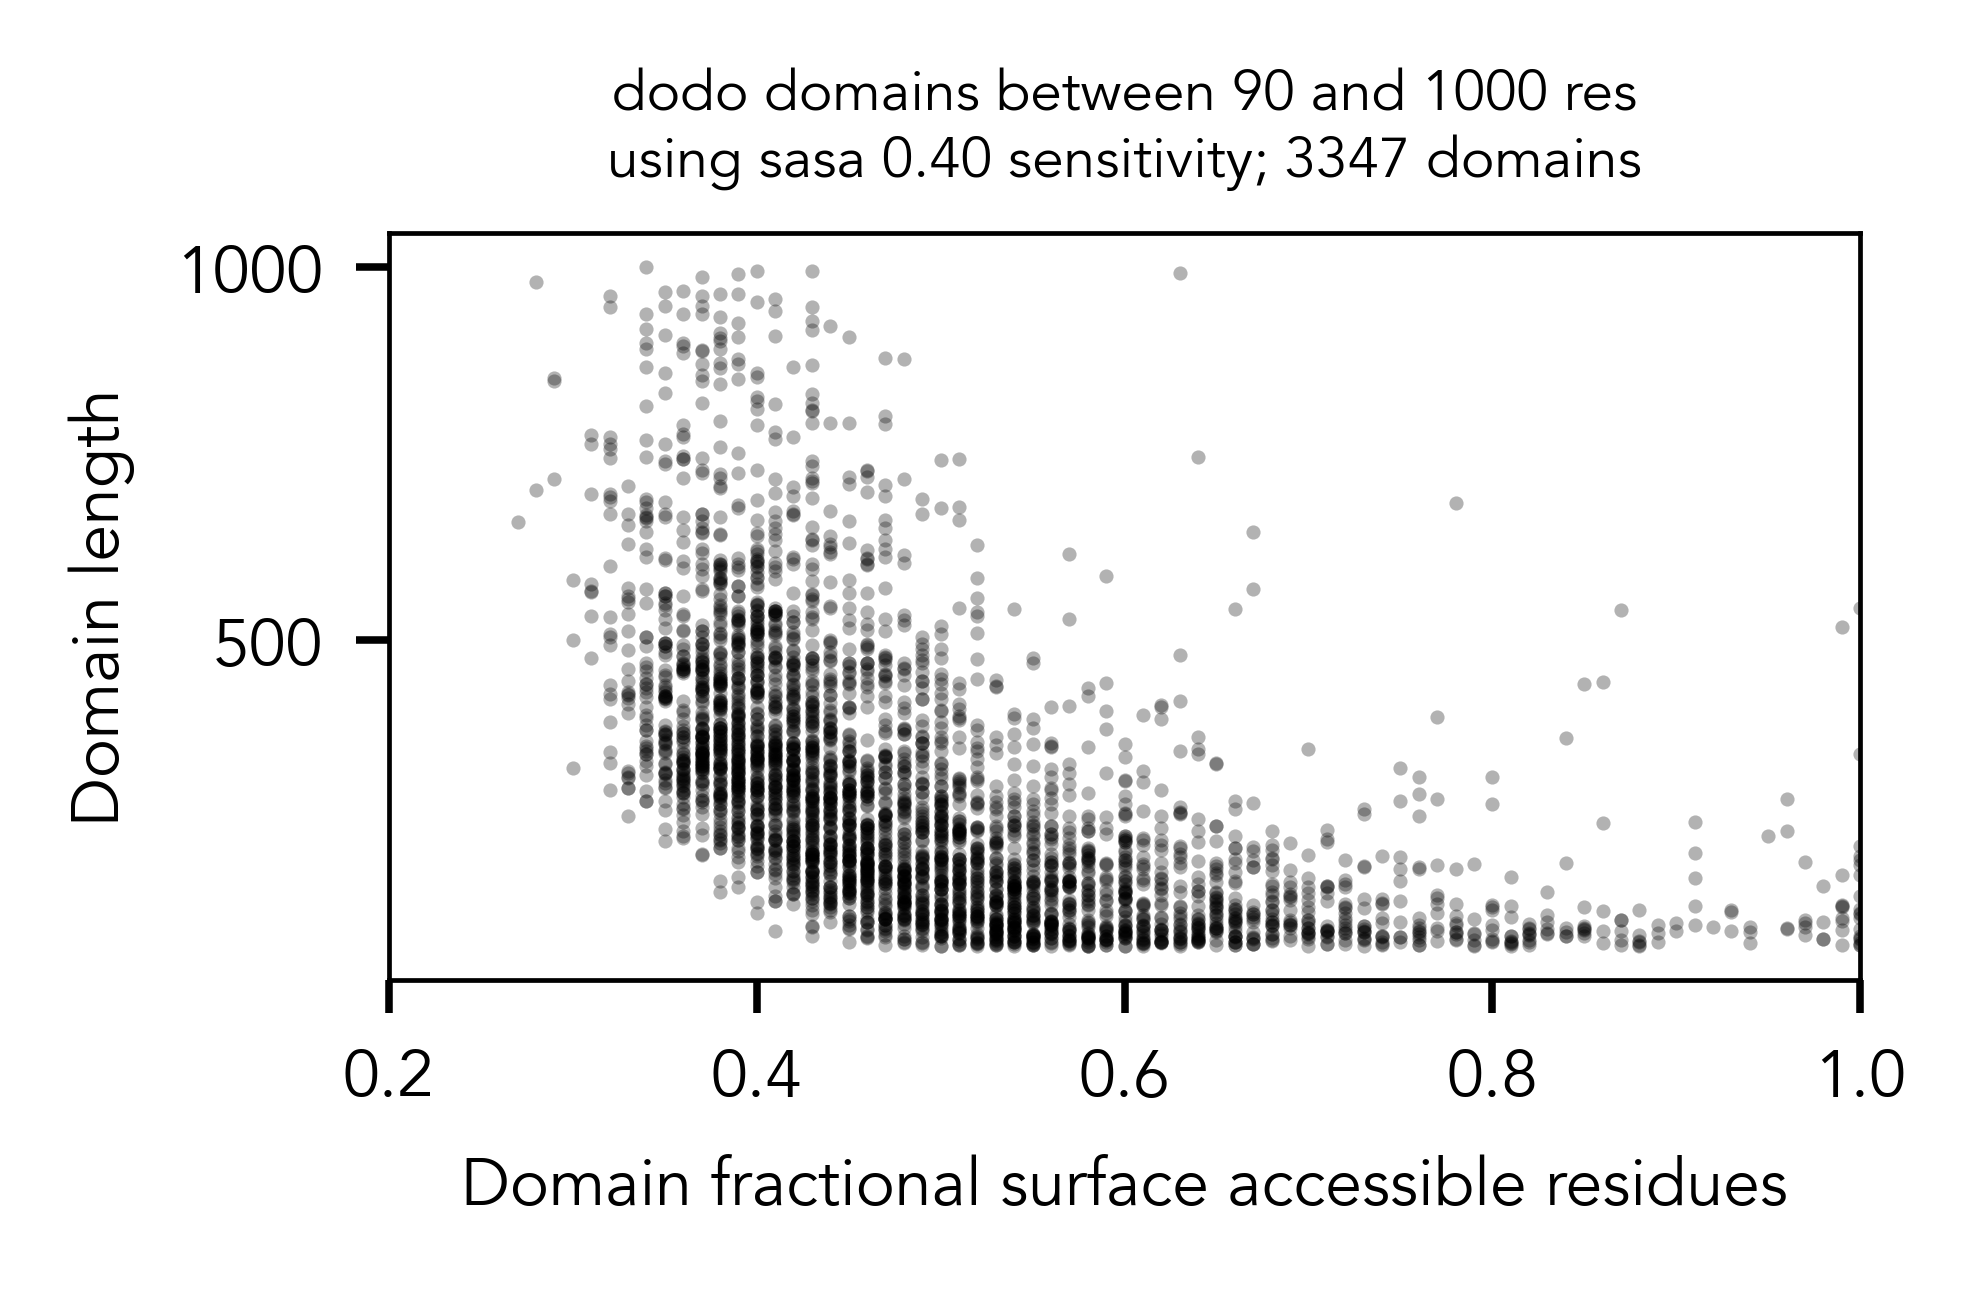

In [20]:
all_sasa_vals = []
all_lengths = []
for d in yp.domains:    
    all_sasa_vals.append(d.attribute('fraction_sasa'))
    all_lengths.append(len(d))

figure(None, (3,2), dpi=340)

ax = plt.gca()

plt.plot(all_sasa_vals, all_lengths,'.k', ms=3, alpha=0.3,mew=0)

plt.ylabel('Domain length',fontsize=7)
plt.yticks(fontsize=7)
plt.xlim([0.2,1.0])
plt.xlabel('Domain fractional surface accessible residues',fontsize=7)
plt.xticks(fontsize=7)
plt.title(f"{domain_def} domains between {min_size_threshold} and {max_size_threshold} res\nusing sasa 0.{sasa_sensitivity_factor} sensitivity; {len(yp.domains)} domains", fontsize=6)

fs = f"outfigures_surface_chemistry/{domain_def}/len_vs_fracsa_{mode_name}_{sasa_sensitivity_factor}_{min_size_threshold}_{max_size_threshold}_{max_sasa_threshold}.pdf"
plt.tight_layout()
plt.savefig(fs)



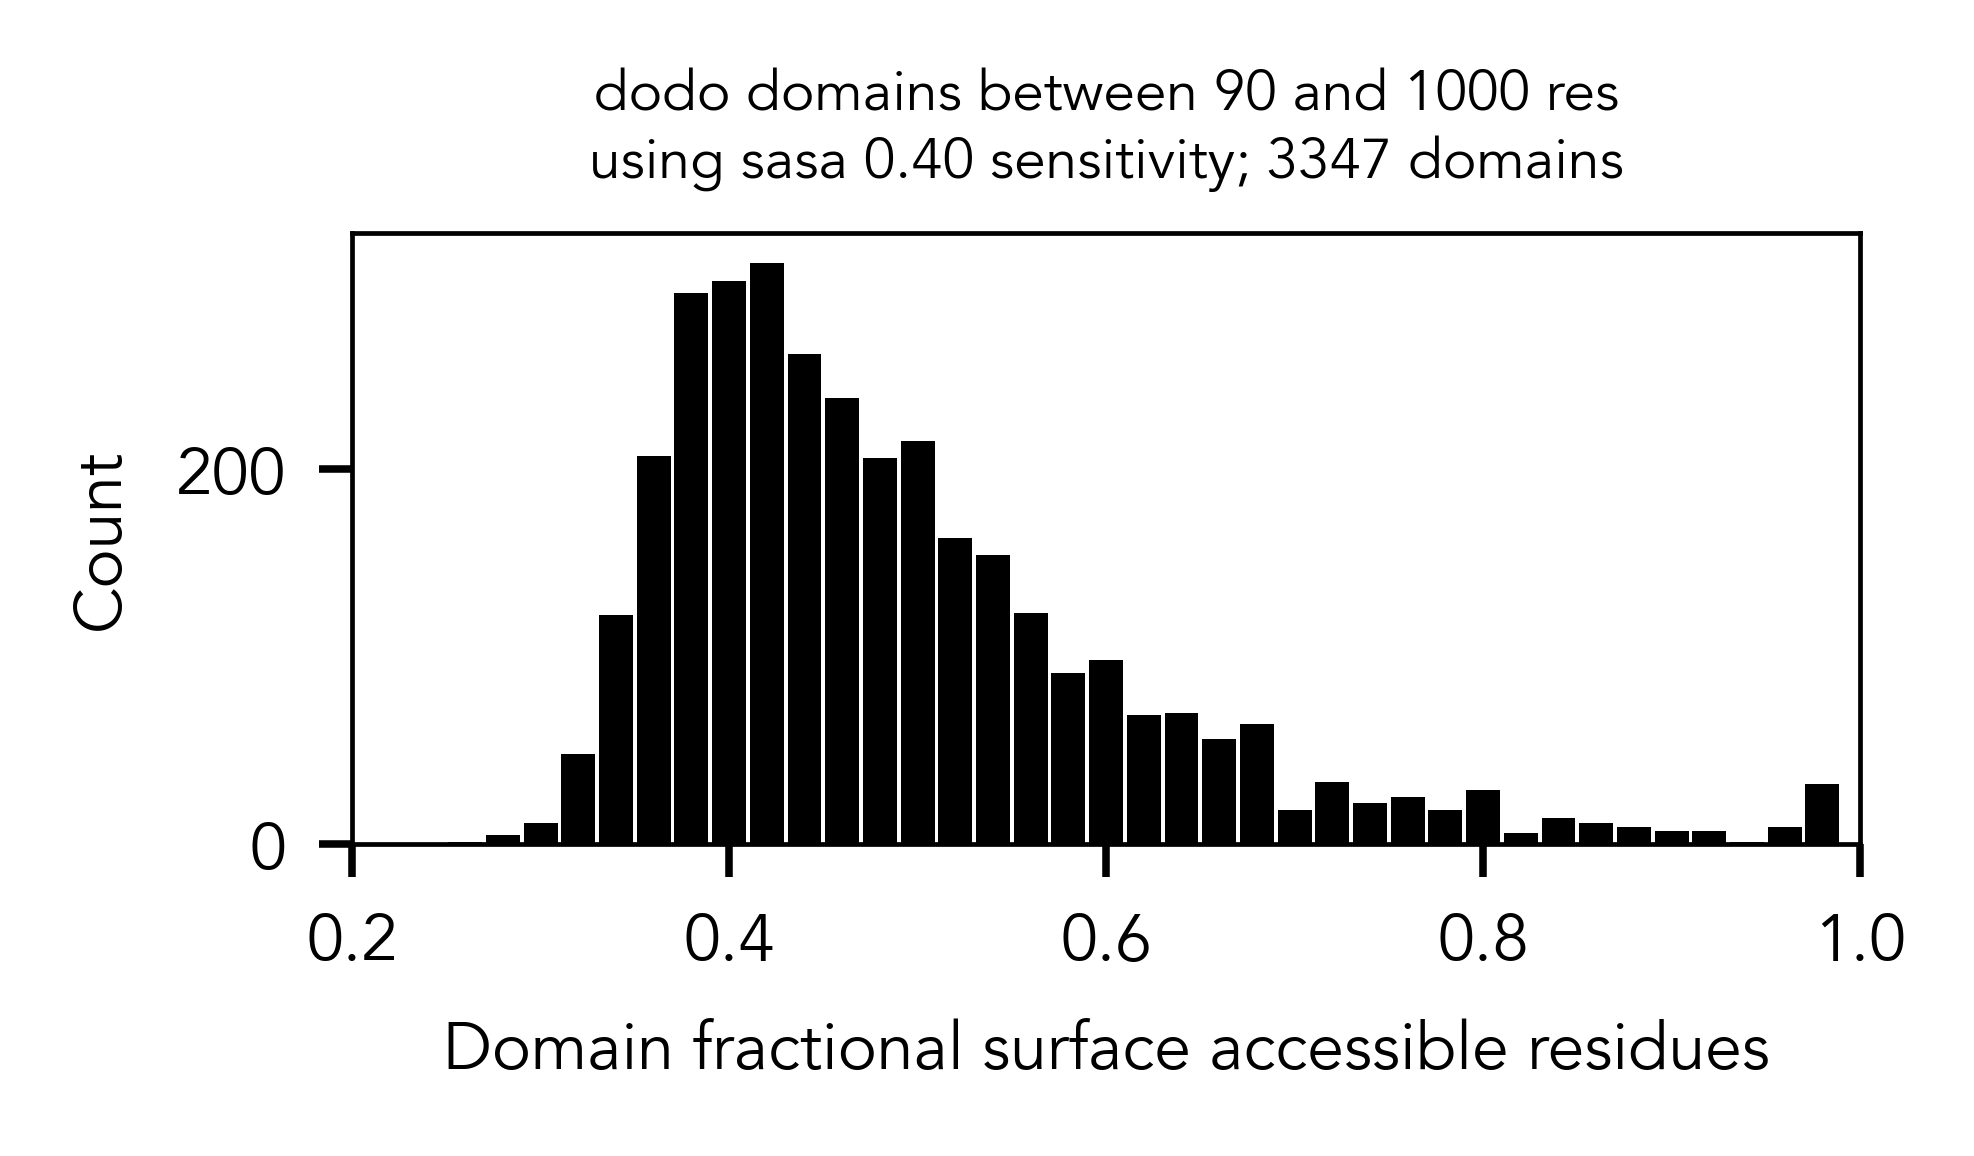

In [21]:
#
# We then also examine histogram of fraction SASA for all those domains
#

figure(None, (3,1.8), dpi=340)

ax = plt.gca()
bin_size=0.02
bins = np.arange(0.0,1+bin_size,bin_size)
X = np.histogram(all_sasa_vals, bins=bins)
bar_offset = 8

plt.bar(X[1][:-1][5:], X[0][5:], width=bin_size*0.9, color='k')
plt.xlim([0.2,1.0])
plt.ylabel('Count',fontsize=7)
plt.yticks(fontsize=7)

plt.xlabel('Domain fractional surface accessible residues',fontsize=7)
plt.xticks(fontsize=7)

ax.axvline(max_sasa_threshold, color='r',lw=0.3)
plt.title(f"{domain_def} domains between {min_size_threshold} and {max_size_threshold} res\nusing sasa 0.{sasa_sensitivity_factor} sensitivity; {len(yp.domains)} domains", fontsize=6)
plt.tight_layout()

fs = f"outfigures_surface_chemistry/{domain_def}/fracsa_histo_{mode_name}_{sasa_sensitivity_factor}_{min_size_threshold}_{max_size_threshold}_{max_sasa_threshold}.pdf"
plt.savefig(fs)



## Calculate proteome-wide properties
Next, we're going to calculate a 

In [22]:
# this dictionary will hold mapping of quantiles to amino acids on the surface/surface area. 
# This is either counts or SASA and will depend on $mode
quant_to_aa_counts = {}

# this dictionary will hold mapping of quant to ALL amino acids in domains that fall into
# this quantile. This includes surface and non-surface residues. This is ONLY counts and
# will be the same regardless of $mode
quant_to_aa_counts_all = {}

# finally, this keeps track of the count/area of each residue type on the surface across all
# quantiles (i.e. is same as quant_to_aa_counts but collapsed down across all quantiles)
# This is either counts or SASA and will depend on $mode
overall_average_surface_fraction_aa = {}
for AA in VALID_AMINO_ACIDS:
    overall_average_surface_fraction_aa[AA] = 0
    

## BIG LOOP GO FAST

# for each protein
for p in yp:

    
    # if that protein was annotated with a quantile then...
    if 'quantile' in p.attributes:

        # if this quantile has never been seen before initialize the
        # associated dinctionaries appropriately 
        if p.attribute('quantile') not in quant_to_aa_counts:
            quant_to_aa_counts[p.attribute('quantile')] = {}
            quant_to_aa_counts_all[p.attribute('quantile')] = {}

            # initialize counts
            for aa in VALID_AMINO_ACIDS:
                s = f"{aa}_SASA{mode}"
                quant_to_aa_counts[p.attribute('quantile')][s] = 0
                quant_to_aa_counts_all[p.attribute('quantile')][aa] = 0

        
        # for each amino acid 
        for aa in VALID_AMINO_ACIDS:

            # define the name of the attribute (mode here will be either nothing or _count,
            # which defines if we're looking at SASA area in A^2 or counting number of 
            # solvent accessible residues
            s = f"{aa}_SASA{mode}"

            # for each domain in the protein...
            for d in p.domains:

                # update the information for the quant_to_aa_counts, which basically counts the number OR area of residue aa
                # on the surface of all domains in each quantile (depends on what $mode is set to)
                # NB: we need the if statement here cos some protein lack specific amino acids on their surface
                if s in d.attributes:                    
                    quant_to_aa_counts[p.attribute('quantile')][s] = quant_to_aa_counts[p.attribute('quantile')][s] + d.attribute(s)                    

                    # we also add this information to the OVERALL dictionary (i.e. not broken down by quantile) \
                    # nb at this point we're not normalizing... (that happens at end)
                    overall_average_surface_fraction_aa[aa] = overall_average_surface_fraction_aa[aa] + d.attribute(s)

            # we also just track the residue counts across the whole domain (ignoring whether residues are on the surface or not)
            # note this is ONLY counts and will not be area.
            for d in p.domains:
                quant_to_aa_counts_all[p.attribute('quantile')][aa] = quant_to_aa_counts_all[p.attribute('quantile')][aa] + d.sequence.count(aa)
                
# normalize so the dictionary values add up to 1 (i.e. what fraction of all surface residues are A,C,D,...W
overall_average_surface_fraction_aa = {AA:overall_average_surface_fraction_aa[AA]/np.sum(list(overall_average_surface_fraction_aa.values())) for AA in overall_average_surface_fraction_aa}
                    
# note at this stage
# quant_to_aa_counts = dictionary where keys are quantiles and values are dictionaries that map X_SASA_Y : <count or area> for all domains 
# of proteins in that quantile, where X == amino acid and Y defines the mode
#
# quant_to_aa_counts_all = dictonary where keys are quantiles and values are dictionarys that map each aino acid to the total number of 
# time that residue was seem in proteins associated with that quantile.
    

## Calculate some normalized values
The cell below calculates two normalized dictionaries, `quant_to_aafracs` and `quant_to_aafracs_all`.

`quant_to_aafracs` is a dictionary where each key is a quantile, and then the value is another dictionary that maps the fraction of the surface that is each of the 20 amino acids. "Fraction" here is either fraction in terms of count, or fraction in terms of surface area. So for example if we're in `_count` mode then:

    quant_to_aafracs[78]['E_SASA_count']

Would return the fraction of surface residues for proteinss in the 78th percentile (7/8 quantile) that are glutamtic acid.

`quant_to_aafracs_all` is a dictionary where each key is a quantile, and then the value is another dictionary that maps the fraction of all residues that is each of the 20 amino acids. "Fraction" here is ONLY fractional count because this includes surface and internal residues.

So for example :

    quant_to_aafracs_all[78]['E']

Would return the fraction of residues in proteins in the 78th percentile (7/8 quantile) that are glutamtic acid.

In [23]:
#
# see above for explanation for what be goin on here
#

quant_to_aafracs = {}

# for each quantile
for quantile in quant_to_aa_counts:

    # convert the number of residues or area associated with a specific residue into a fraction; here our denominator is total count of surface residues
    # for all domains in this quantile, or total area (in A^2) for all domains in this quantile
    quant_to_aafracs[quantile] = {x:quant_to_aa_counts[quantile][x]/sum(quant_to_aa_counts[quantile].values()) for x in quant_to_aa_counts[quantile]}



# quant_to_aa_counts = dictionary where keys are quantiles and values are dictionaries that map X_SASA_X : <fraction> of residues or area
# of proteins in that quantile REGARDLESS of if they are surface residues or not. BUT NOTE - this only makes sense for COUNTS, so is 
# only counts
quant_to_aafracs_all = {}
for quantile in quant_to_aa_counts_all:
    quant_to_aafracs_all[quantile] = {x:quant_to_aa_counts_all[quantile][x]/sum(quant_to_aa_counts_all[quantile].values()) for x in quant_to_aa_counts_all[quantile]}




# Write out data
The cell below writes out a bunch of data associated with the analysis done so far for further downstream processing, as needed

In [24]:
with open(f'outdata/surface_composition_annotation_{domain_def}_{mode_name}_{sasa_mode}_{sasa_sensitivity_factor}.csv', 'w') as fh:

    fh.write('UniProt, domain_start, domain_end, S_over_T_mean, S_over_T_pval, quantile, refoldable, subcellular_localization, average_KD_hydro, ' +" , ".join([f"{aa}_SASA{mode}" for aa in VALID_AMINO_ACIDS])+"\n")
    
    for p in yp:
    
        # if that protein was annotated with a quantile
        if 'quantile' in p.attributes:
            
            for d in p.domains:

                ## ----- calculate per-domain average surface Kyte-Doolite (KD) hydrophobicity
                # to calculate KD hydrophobicity for surfaces residues we have to first
                # work out fraction of surface residues that are each amino acid, and then
                # multiply the KD value for that amino acid by the fraction of the residues
                total_surface_res = 0
                for aa in VALID_AMINO_ACIDS:
                    s = f"{aa}_SASA_count"
                    
                    if s in d.attributes:
                        total_surface_res = total_surface_res + d.attribute(s)
                tmp_kd = 0
                for aa in VALID_AMINO_ACIDS:                    
                    s = f"{aa}_SASA_count"
                    if s in d.attributes:
                        tmp_kd = tmp_kd + Protein(aa).hydrophobicity*(d.attribute(s)/total_surface_res)
                        
                ## ---- end of KD section



                # initailize the output string
                domain_string = ''

                # add in various things
                domain_string = f'{p.unique_ID}, {d.start}, {d.end}, {p.attribute("S_over_T_mean")}, {p.attribute("S_over_T_pval")}, {p.attribute("quantile")}, {p.attribute("refoldable")}, {p.attribute("subcellular_localization").replace(",",";")}, {round(tmp_kd,3)}, '

                # now for each amino acid add the value (note we explicitly include a 0 if there are none of those 
                # residues on the surface just for consistency in writing the CSV file (otherwise everything breaks
                # down!!
                for aa in VALID_AMINO_ACIDS:
                    s = f"{aa}_SASA{mode}"
                    if s in d.attributes:
                        domain_string = domain_string + f", {d.attribute(s)}"
                    else:
                        domain_string = domain_string + f", 0"

                # write the string
                fh.write(domain_string)

                # newline
                fh.write('\n')


## Plot heatmap of how surface chemistry is changing across quantiles
Next up, we will generate a heatmap with NORMALIZED amino acid fractions to capture trends in how these change as a function of resolublity. In particular, we we look at the average fractional content of surface residues in each percentile, and then scale that so it goes from max 1 and min 0 so we can plot all amino acids on the same heatmap


25


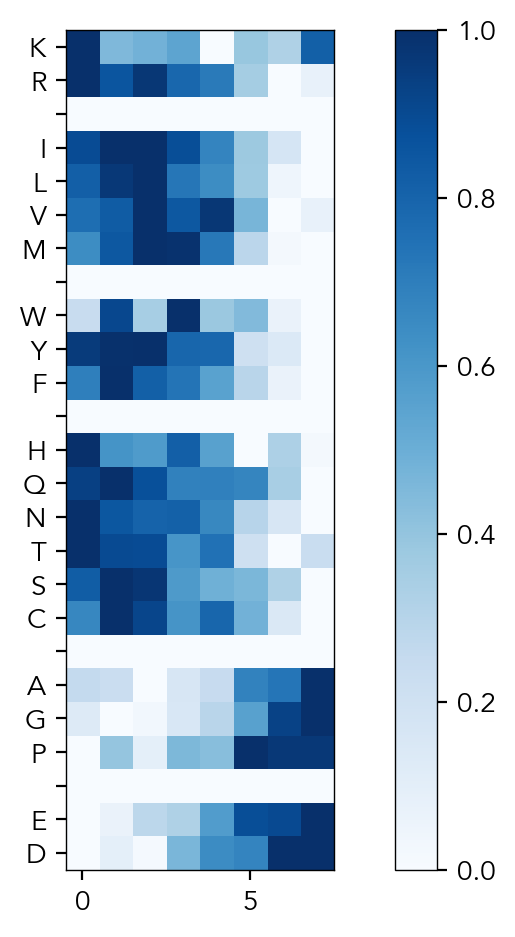

In [25]:
# our 'sensible order' here groups physicochemically similar amino acids
# together
sensible_order = ['K','R','','I','L', 'V','M', '','W','Y','F','','H','Q','N','T','S','C', '', 'A','G','P','','E','D']

# initialize some things
all_vals = []
all_vals_raw = []

# ensible order full is the unhelpfully named variable which has the same order
# as described in 'sensible order' but without empty strings...
sensible_order_full = [i for i in sensible_order if i != '']

# quantiles bars here is gonna be a dictionary that quantifies for each quantile
# the surface fraction of each AA vs. the AVERAGE surface fraction that amino 
# acid is across all quantiles. This lets us get a sense of the magnitude of trends
# in terms of normalized surface abundance across different quantiles
quantile_bars = {}



for aa in sensible_order:
    aa_string = f"{aa}_SASA{mode}"

    tmp = []

    # if an empty string was passed...
    if aa_string == f'_SASA{mode}':
        for q in QUANTILE_REF:
            tmp.append(0)
        all_vals.append(tmp)
    else:
        # tmp here gets populated with the fraction of amino acid AA in this quantile
        # (where fraction comes from either rescount or surface area, depending on $mode)
        # divided by the fraction that amino acid is present on the surface of ALL domains
        for q in QUANTILE_REF:
            tmp.append(quant_to_aafracs[q][aa_string]/overall_average_surface_fraction_aa[aa])

        
        all_vals.append(normalize_array(np.array(tmp)))        
        all_vals_raw.append(np.array(tmp))        
        
        quantile_bars[aa] = tmp        
        
plt.imshow(np.array(all_vals), cmap='Blues')
plt.yticks(np.arange(0,len(sensible_order)),sensible_order)
print('')
print(len(sensible_order))
plt.colorbar()
plt.tight_layout()

fs = f"outfigures_surface_chemistry/{domain_def}/quantiled_surface_chemistry_{mode_name}_{sasa_sensitivity_factor}_{min_size_threshold}_{max_size_threshold}_{max_sasa_threshold}.pdf"
plt.savefig(fs)


In [26]:

for aa in VALID_AMINO_ACIDS:
    figure(None, (5,2.5), dpi=450)
    ax = plt.gca()
    plt.plot(QUANTILE_REF, quantile_bars[aa], '.k-', lw=0.8)
    #plt.yscale('log')
    #plt.ylim([0.6,1.4])
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(f"{domain_def} ({mode_name}), Amino acid: {aa}",fontsize=10)
    plt.xlabel('Percentile', fontsize=9)
    plt.ylabel('Normalized\nabundance', fontsize=9)
    
    ax.axhline(1,lw=0.5, color='b', ls='--')
    plt.tight_layout()
    plt.savefig(f'outfigures_surface_chemistry/{domain_def}/amino_acids/{aa}_{mode_name}.pdf')
    plt.close()
    
        
    

In [27]:

quant_to_pos = []
quant_to_neg = []
quant_to_kd = []

for q in QUANTILE_REF:
    tmp_neg = 0
    tmp_pos = 0
    tmp_kd = []
    
    for aa in ['E','D']:
        s = f"{aa}_SASA{mode}"
        tmp_neg = tmp_neg + quant_to_aa_counts[q][s]

    for aa in ['R','K']:
        s = f"{aa}_SASA{mode}"
        tmp_pos = tmp_pos + quant_to_aa_counts[q][s]
    
    all_aa = 0
    for aa in VALID_AMINO_ACIDS:
        s = f"{aa}_SASA{mode}"
        all_aa = all_aa + quant_to_aa_counts[q][s]

    tmp_kd = 0
    for aa in VALID_AMINO_ACIDS:
        s = f"{aa}_SASA{mode}"
        tmp_kd = tmp_kd + Protein(aa).hydrophobicity*quant_to_aa_counts[q][s]
        
    
    quant_to_pos.append(tmp_pos/all_aa)
    quant_to_neg.append(tmp_neg/all_aa)
    quant_to_kd.append(tmp_kd/all_aa)
        
    

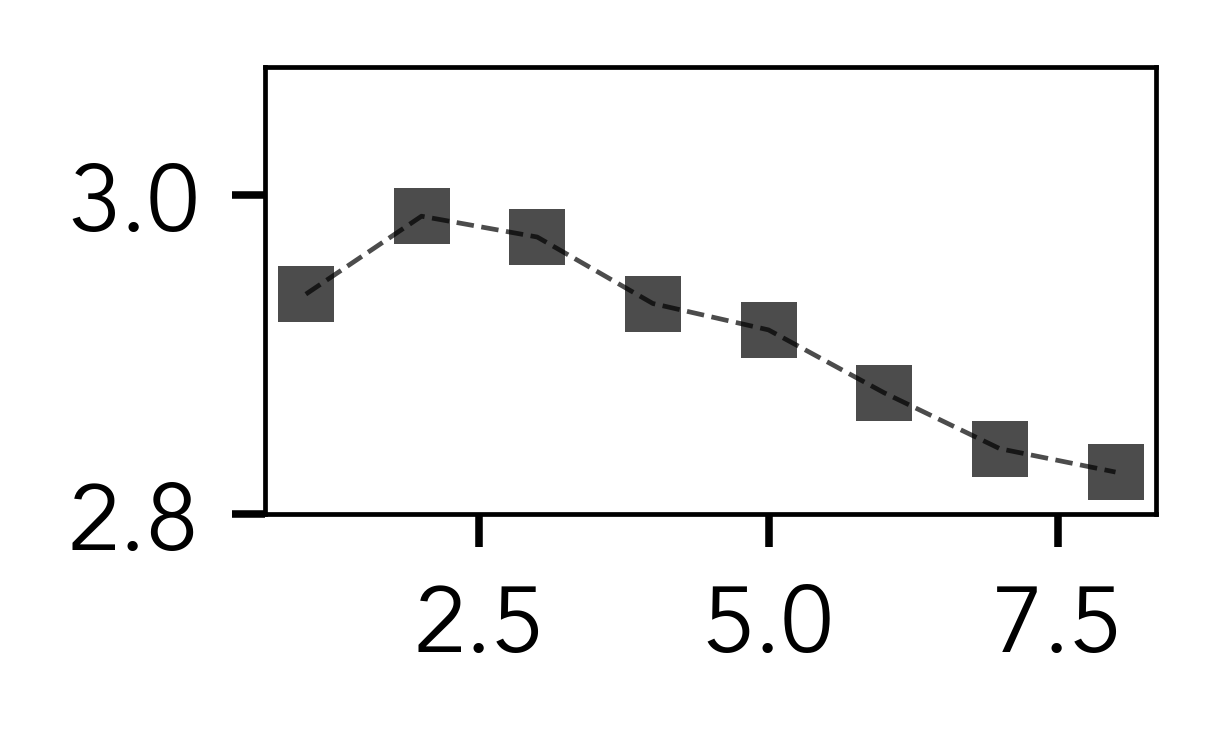

In [28]:
if domain_def == 'dodo':
    figure(None, (1.9,1.2), dpi=340)
    idx = np.arange(1,len(QUANTILE_REF)+1)
    plt.plot(idx, quant_to_kd,  's--',color='k', alpha=0.7, lw=0.5,mew=0)
    
    if mode == '_count':
        plt.ylim([2.80,3.08])
    elif mode == '':
        plt.ylim([2.3, 2.76])
    
    plt.tight_layout()
    plt.savefig(f'outfigures/dodo_surface_hydrophobicity_{mode_name}.pdf')    

elif domain_def =='chainsaw':
    figure(None, (2.5,1.2), dpi=340)
    idx = np.arange(1,len(QUANTILE_REF)+1)
    plt.plot(idx, quant_to_kd,  's--',color='k', alpha=0.7, lw=0.5,mew=0)

    if mode == '_count':
        plt.ylim([2.97,3.08])
    elif mode == '':
        plt.ylim([2.56, 2.76])
    plt.tight_layout()
    plt.savefig(f'outfigures/chainsaw_surface_hydrophobicity_{mode_name}.pdf')

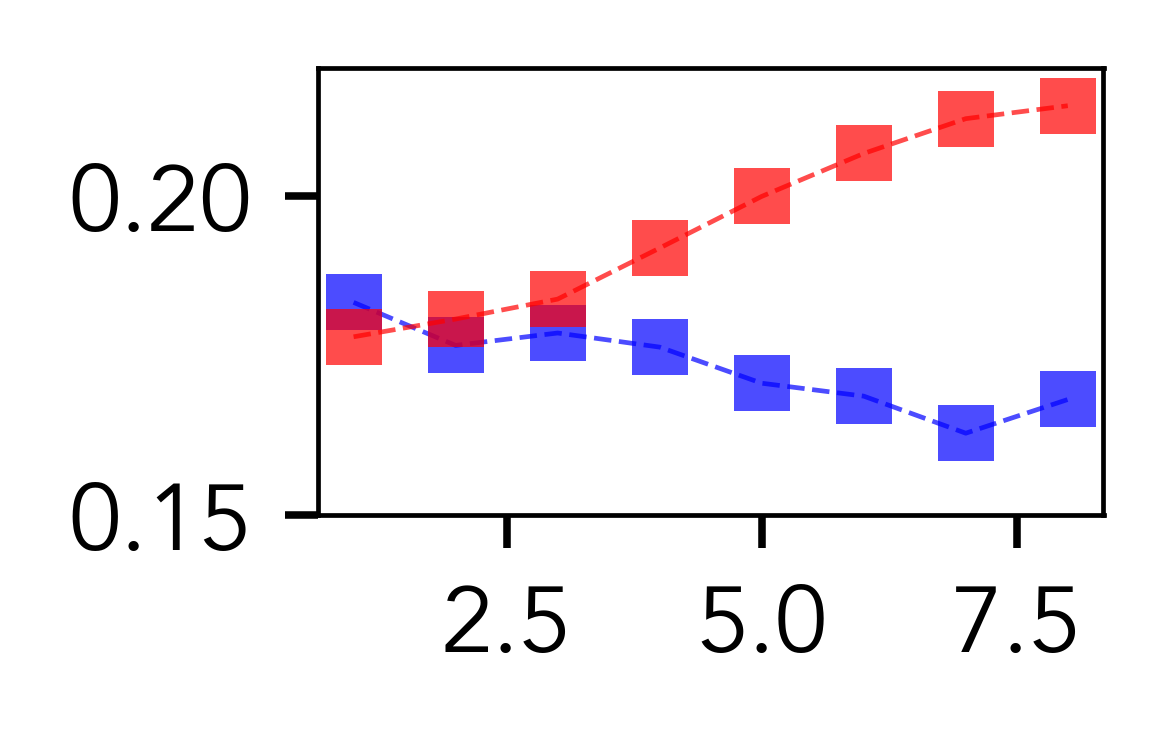

In [29]:
if domain_def == 'dodo':
    figure(None, (1.9,1.2), dpi=340)

    if mode == '_count':
        plt.ylim([0.15,0.22])
    elif mode == '':
        plt.ylim([0.16,0.28])
            
    

elif domain_def =='chainsaw':
    figure(None, (2.5,1.2), dpi=340)

    if mode == '_count':
        plt.ylim([0.145,0.21])
    elif mode == '':
        plt.ylim([0.18,0.26])

    

idx = np.arange(1,len(QUANTILE_REF)+1)
plt.plot(idx, quant_to_pos,  's--',color='b', alpha=0.7, lw=0.5,mew=0)
plt.plot(idx, quant_to_neg,  's--',color='r', alpha=0.7, lw=0.5,mew=0)

    


plt.tight_layout()
plt.savefig(f'outfigures/{domain_def}_surface_charge_{mode_name}.pdf')
